In [2]:
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi
import xarray as xr
import glob
import math
from geopy.distance import geodesic
from scipy.interpolate import griddata

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import wrapSpectra, spectra, sat, plot_sat, model, fireworks
from lib.config import * 


# Swell Field reconstruction

Storm source identification

**Satellite tracks data - Mfwam model data**

In [3]:
# coords: (file, nbox, posneg), vars: (longitude, latitude, time)
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))
ds_ww3 = xr.open_dataset(op.join(p_output, 'ww3_wind.nc'))
ds = xr.open_dataset(op.join(p_output, 'params_BINS.nc'))

## CFOSAT k, dir information

Wave number and Direction of propagation given by the SWIM spectra

In [4]:
# From ds_data and ds - > nbox, nadir, file = f (longitude, latitude)
ds_input = xr.merge([ds_data, ds])
ds_input = ds_input.where((ds_input.T >= 12) & (ds_input.H > 0), drop=True)
ds_input = ds_input.rename({'theta':'dir', 'H':'hs', 'T':'Tp'})


In [5]:
ds_input = ds_input.to_dataframe().reset_index().dropna()

## Retro-propagation

All observations past-positions are calculated following geodesics at group velocity in the direction opposite to the direction of propagation until land is reached and for a maximum time of 14 days. Group velocity is estimated from dominant wavelength using linear dispersion relation, valid for swell with small steepness. (Romain)

Along this past trajectory, the fact that the generation region is detected depends on two conditions. First, a minimum number of swell observations have to converge to this region. This condition is referred to as refocusing and it is further detailed afterwards. Second, the local sea surface wind speed has to reach a threshold value compatible with the swell wavelength. Indeed, a wave of peak period Tp requires a threshold wind speed Umin
around 0.12gTp to be generated, where g is the Earth gravity. The auxiliary wind speed is given by the WW3 10m wind speed.

In practice, because of the inability of input wind data to describe the highest wind speed range, we consider a limit wind speed equal to two-thirds of Umin. Thanks to this wind speed threshold, cross sea regions occurring under calm wind conditions are rightfully rejected from the following storm detection.

In [6]:
folder = 'fireworks_BINS'
#fireworks.calculate_fireworks(ds_input, ds_ww3, folder)

In [7]:
dst = xr.open_mfdataset(glob.glob(op.join(p_output, folder, '*')),
                       engine='netcdf4', combine='nested', concat_dim='case', parallel=True)


## 2D Density maps

**Romain Husson 2012**

It is based on the analysis of retro-propagated swell density-maps over time. These densitymaps are 2D histograms indicating, for a given time step, the number of retro-propagated observations whose threshold wind speed condition is fulfilled within each cell. The density-map geographical extension covers all longitudes, and goes from 74◦S to 74◦N with 2 2◦ cells. This resolution is justified by the limited precision on the swell retro-propagated observations’ location, caused by the error on the swell peak period and direction measurements and the resulting mis-positioning after retro-propagation. In order to be able to compare density-map cells at different latitudes, each cell value is normalized by the cell surface.

In [24]:
time_range = [datetime.datetime(2021, 5, 19),
              datetime.datetime(2021, 5, 20)]
              
ds_delta = dst.sel(date=slice(time_range[0], time_range[1]))

# to handle with the dataset
splits = np.split(ds_delta.case.values, 10)


In [25]:
df = pd.DataFrame()
for ps, spts in enumerate(splits):
    
    sys.stdout.write('\r Case number: {0}\{1}'.format(ps,len(splits)))
    sys.stdout.flush()
    
    dfi = ds_delta.isel(case=slice(int(spts[0]), int(spts[-1]))).to_dataframe().dropna()
    df = pd.concat([df, dfi])
    

 Case number: 9\10

In [26]:
df = df.reset_index()

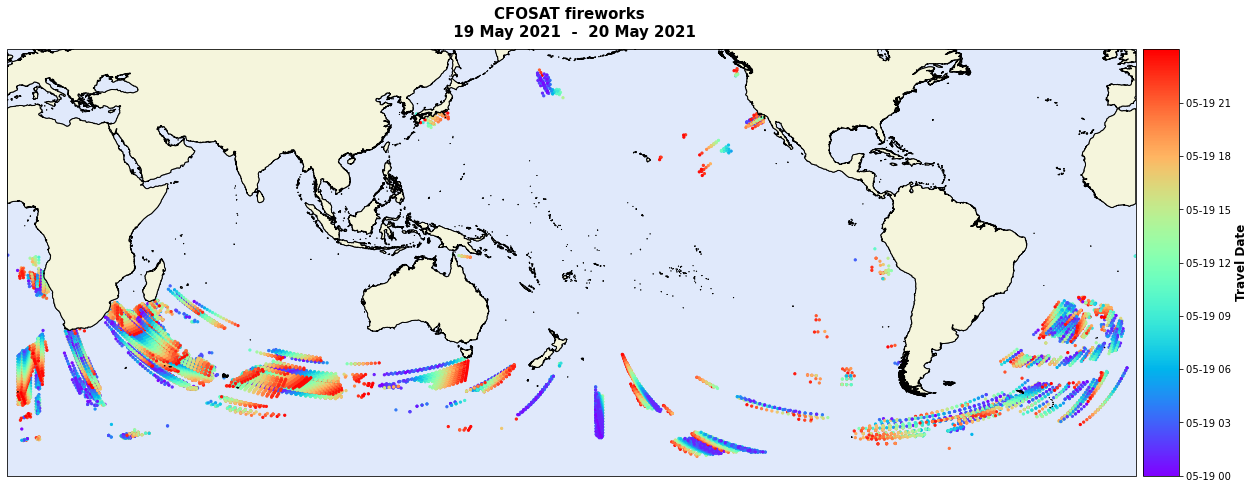

In [27]:
# create datetime colorbar
cmap = plt.cm.rainbow  
t = mdates.date2num(df.date.values)
vmin, vmax = t.min(), t.max()
    
figsize=(21, 21)
fig, ax = plot_sat.map_init(figsize)
ax = plot_sat.map_settings(ax)
ax.add_feature(shape_feature_l)

# plot past observations
im = ax.scatter(df.lon, df.lat, c=mdates.date2num(df.date.values), 
                vmin=vmin, vmax=vmax,
                s=5, cmap=cmap, transform=ccrs.PlateCarree())

ax.set_title('CFOSAT fireworks \n {0}  -  {1}'.format(time_range[0].strftime('%d %B %Y'), time_range[1].strftime('%d %B %Y')), fontsize=15, weight='bold', pad=13)

# plt colorbar
axc, loc = plot_sat.add_colorbar(ax)
fig.add_axes(axc)
cb = plt.colorbar(im, cax=axc, ticks=loc,
             format=mdates.AutoDateFormatter(loc),)# extend='min'
cb.set_label(label='Travel Date', size='large', weight='bold')
#ax.legend(title='Hs(m)', fontsize=15)
plt.show()


In [23]:
df

case       date        lat        lon
0  19428.0 2021-05-19 -46.148349  46.002539

## Storm-source 2D density map

In [10]:
# settings
dxlon = 2
dylat = 2
binsx = np.arange(-180, 180, dxlon)
binsy = np.arange(-90, 90, dylat)
regGrid = np.zeros((len(binsy), len(binsx))) * np.nan

for plat, lat in enumerate(binsy[:-1]):
    for plon, lon in enumerate(binsx[:-1]):
        sub = dataframe.loc[(dataframe.lon >= lon) & (dataframe.lon < binsx[plon+1]) & (dataframe.lat >= lat) & (dataframe.lat < binsy[plat+1])]
        if not sub.empty:
            # Wind-speed cut
            regGrid[plat, plon] = len(sub)


In [13]:
# Minimun number of observations 
regGrid[np.where(regGrid < 6)] = np.nan

In [11]:
X, Y = np.meshgrid(binsx, binsy)

# Smooth Storm area
newx = np.arange(-180, 180, 0.1)
newy = np.arange(-60, -10, 0.1)
Xn, Yn = np.meshgrid(newx, newy)

points = np.vstack([np.reshape(X, np.shape(X)[0]*np.shape(X)[1]), np.reshape(Y, np.shape(Y)[0]*np.shape(Y)[1])]).T
values = np.reshape(regGrid, np.shape(regGrid)[0]*np.shape(regGrid)[1])

data = griddata(points, values, (Xn, Yn), method='linear')


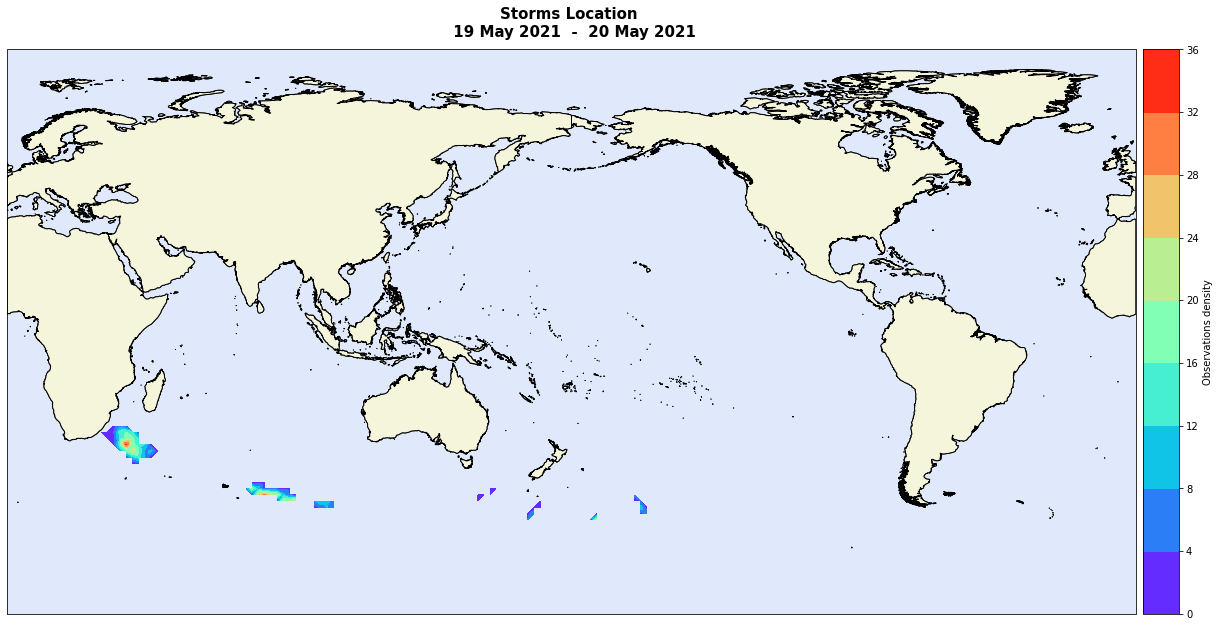

In [12]:
figsize=(21, 21)
fig, ax = plot_sat.map_init(figsize)
ax = plot_sat.map_settings(ax)
ax.add_feature(shape_feature_l)

im = ax.contourf(Xn, Yn, data,
                 cmap='rainbow', transform=ccrs.PlateCarree(), zorder=2)

ax.set_title('Storms Location \n {0}  -  {1}'.format(time_range[0].strftime('%d %B %Y'), time_range[1].strftime('%d %B %Y')), fontsize=15, weight='bold', pad=13)

# plt colorbar
axc, loc = plot_sat.add_colorbar(ax)
fig.add_axes(axc)
ax.set_extent([-180, 180, -90, 90])
plt.colorbar(im, cax=axc, label='Observations density')
ax.grid('on')
plt.show()

## Swell events association

In [ ]:
# plot
ax.scatter(ds_time.longitude.values[ds_time.hs.values < 1], 
           ds_time.latitude.values[ds_time.hs.values < 1], 
           s=5, c='k', label = '< 1m',
           transform=ccrs.PlateCarree(), zorder=3)

ax.scatter(ds_time.longitude.values[(ds_time.hs.values > 1) & (ds_time.hs.values < 3)], 
           ds_time.latitude.values[(ds_time.hs.values > 1) & (ds_time.hs.values < 3)], 
           s=15, c='k', label = '1m - 3m',
           transform=ccrs.PlateCarree(), zorder=3)

ax.scatter(ds_time.longitude.values[ds_time.hs.values > 3], 
           ds_time.latitude.values[ds_time.hs.values > 3], 
           s=20, c='k', label = '> 3m',
           transform=ccrs.PlateCarree(), zorder=3)